This is the third enstallment in a series on the Singular Value Decomposition (SVD). In this series we have looked at some of the many important use cases of the SVD and we have gained some intution about how each of the matrix factors relate to the each other and to the original data. Today I'd like to focus on a pragmatic concern pertaining to the SVD: computing the SVD for large matrices.

With the sizes of datasets today, computational efficiency has become an increasingly pressing issue. While there are many important data analytic techniques that work well for small problems, many algorithms do not scale well to large datasets. The SVD is one such technique. It is a relatively expensive operation and considering its widespread use, any improvements in the speed of computing the SVD would be hugely beneficial.

[Randomized algorithms](https://arxiv.org/abs/0909.4061) offer precisely this computational improvement. By randomly sampling the data matrix, projecting the data into a basis formed from that sampling, computing the SVD on the resulting smaller matrix, and applying the inverse transform on the result, we can substantially speedup our decomposition and maintain accurate results (see technical discussion at the end). The same kind of procedure applies to higher dimensional problems like tensor decomposition. In this post, we'll examine the randomized SVD algorithm, have a look at some applications, and see how we can use it in Python.


## The randomized SVD algorithm

The basic idea behind the rSVD is compute the SVD on a much smaller matrix than our original data in a way that returns the first `r` modes. We can use the following steps to achieve this:
- randomly sample your data matrix: $XP = Z$ 
- compute the QR factorization of the resulting $Z$ matrix: $Z = QR$
- project our data matrix onto the $Q$ basis: $Y = Q^{T}X$
- compute the SVD of the resulting $Y$ matrix: $Y = U_{y} \Sigma V^{T}$
- project the $Uy$ matrix back: $U = QU_{y}$ 
- return the $U$, $S$, and $V^{T}$ matrices

> For simplicity, I've left out a discussion of power iterations and oversampling. You can learn more about these topics [here](https://arxiv.org/abs/0909.4061).

$X_{(1000, 1000)}=U\Sigma V^T$

$Y_{(r, 1000)}=U_r\Sigma _r V^T_r$

Here's how this algorithm might look in Python:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import timeit
from PIL import Image, ImageOps

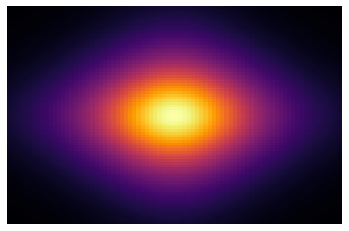

In [2]:
# create our data matrix
x1 = np.linspace(-3, 3, 80)
x2 = np.linspace(-3, 3, 80)
x1grid, x2grid = np.meshgrid(x1, x2)

# make a rank 1 matrix
X = 2/np.cosh(x1grid)/np.cosh(x2grid)
plt.pcolor(x1grid, x2grid, X, shading='auto', cmap='inferno')
plt.axis('off');

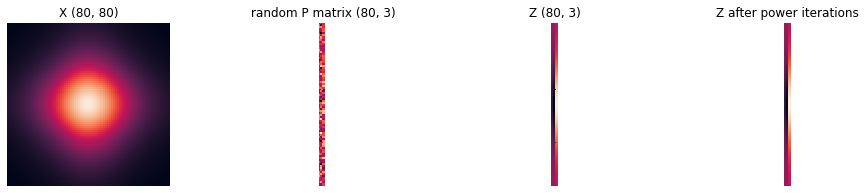

In [3]:
P = np.random.randn(X.shape[1], 1 + 2)
Z = X.dot(P)
Zp = Z
for _ in range(4):
    Zp = X.dot((X.T.dot(Zp)))
        
fig, axs = plt.subplots(1,4, figsize=(16,3))

seaborn.heatmap(ax=axs[0], data=X, cbar=False, square=True)
seaborn.heatmap(ax=axs[1], data=P, cbar=False, square=True)
seaborn.heatmap(ax=axs[2], data=Z, cbar=False, square=True)
seaborn.heatmap(ax=axs[3], data=Zp, cbar=False, square=True)
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[0].set_title(f'X {X.shape}')
axs[1].set_title(f' random P matrix {P.shape}')
axs[2].set_title(f'Z {Z.shape}')
axs[3].set_title(f'Z after power iterations');

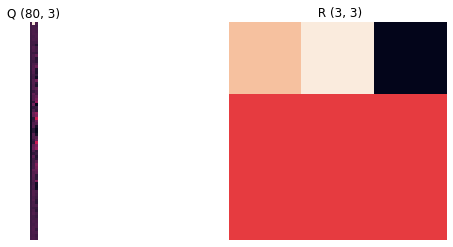

In [4]:
Q, R = np.linalg.qr(Zp, mode='reduced')

fig, axs = plt.subplots(1,2, figsize=(10,4))

seaborn.heatmap(ax=axs[0], data=Q, cbar=False, square=True)
seaborn.heatmap(ax=axs[1], data=R, cbar=False, square=True)
axs[0].axis('off')
axs[1].axis('off')
axs[0].set_title(f'Q {Q.shape}')
axs[1].set_title(f' R {R.shape}');

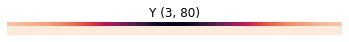

In [5]:
Y = Q.T.dot(X)
seaborn.heatmap(data=Y, cbar=False, square=True)
plt.axis('off')
plt.title(f'Y {Y.shape}');

Text(0.5, 1.0, 'Vt (3, 80)')

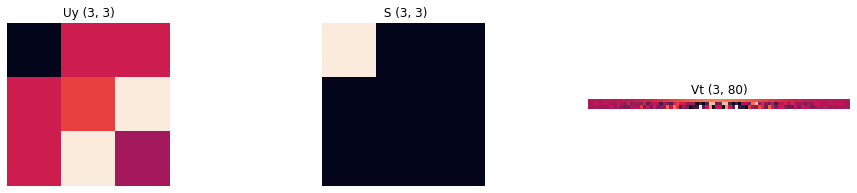

In [6]:
Uy, S, Vt = np.linalg.svd(Y,full_matrices=False)
display_S = np.zeros((S.shape[0], S.shape[0]))
np.fill_diagonal(display_S, S)

fig, axs = plt.subplots(1,3, figsize=(16,3))

seaborn.heatmap(ax=axs[0], data=Uy, cbar=False, square=True)
seaborn.heatmap(ax=axs[1], data=display_S, cbar=False, square=True)
seaborn.heatmap(ax=axs[2], data=Vt, cbar=False, square=True)

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[0].set_title(f'Uy {Uy.shape}')
axs[1].set_title(f' S {display_S.shape}')
axs[2].set_title(f'Vt {Vt.shape}')


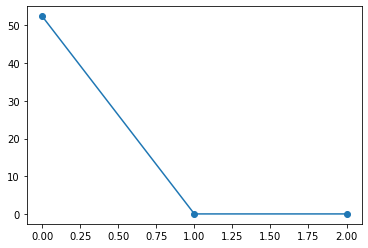

In [7]:
plt.plot(S, '-o')

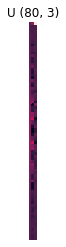

In [8]:
U = Q.dot(Uy)
seaborn.heatmap(U, cbar=False, square=True)
plt.axis('off')
plt.title(f'U {U.shape}');

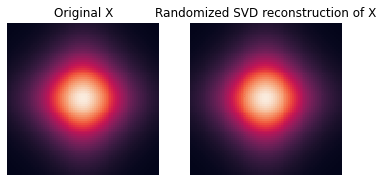

In [9]:
X_reconstruction = U @ np.diag(S) @ Vt

fig, axs = plt.subplots(1,2)

seaborn.heatmap(ax=axs[0], data=X, cbar=False, square=True)
seaborn.heatmap(ax=axs[1], data=X_reconstruction, cbar=False, square=True)
axs[0].axis('off')
axs[1].axis('off')
axs[0].set_title('Original X')
axs[1].set_title('Randomized SVD reconstruction of X');

In [10]:
def rSVD(X, rank, power_iterations=4, n_oversampling=10):
    
    # define the random sampling matrix
    P = np.random.randn(X.shape[1], rank + n_oversampling)
    
    # randomly sample the data matrix
    Z = X.dot(P)
    
    # power iterations
    for _ in range(power_iterations):
        Z = X.dot((X.T.dot(Z)))
    
    # compute the QR factorization
    Q, R = np.linalg.qr(Z, mode='reduced')

    # project our data onto Q
    Y = Q.T.dot(X)
    
    # compute the SVD of our projected data
    Uy, S, Vt = np.linalg.svd(Y,full_matrices=False)
    
    # project Uy back up
    U = Q.dot(Uy)

    return U, S, Vt

## Quality of rSVD approximation



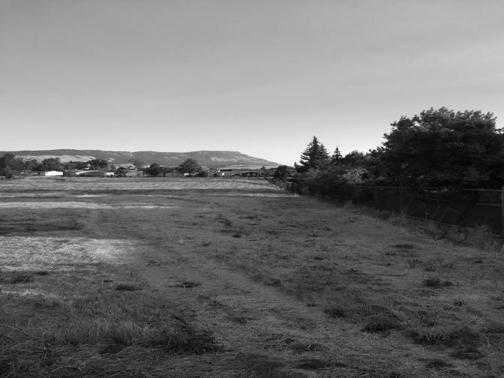

In [11]:
mt_emily = ImageOps.grayscale(Image.open('images/svd1/mt_emily_resized.jpg'))
mt_emily

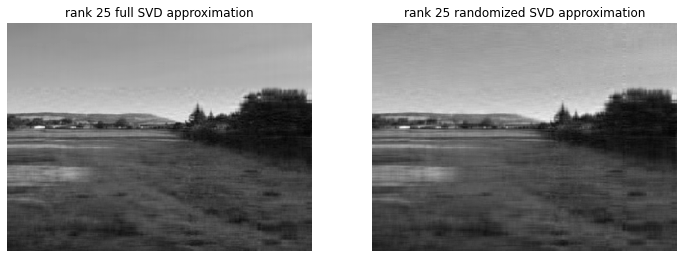

In [12]:
mt_emily = np.array(mt_emily)
r = 25
Ur, Sr, Vtr = rSVD(mt_emily, r)
U, S, Vt = np.linalg.svd(mt_emily)

randomized_approximation = Ur[:,:r] @ np.diag(Sr[:r]) @ Vtr[:r,:]
full_approximation = U[:,:r] @ np.diag(S[:r]) @ Vt[:r,:]

fig, axs = plt.subplots(1,2, figsize=(12,6))

axs[0].imshow(full_approximation, cmap='gray')
axs[1].imshow(randomized_approximation, cmap='gray')
axs[0].axis('off')
axs[1].axis('off')
axs[0].set_title('rank 25 full SVD approximation')
axs[1].set_title('rank 25 randomized SVD approximation');

In [13]:
mt_emily = np.array(mt_emily)
ranks = np.arange(1, 300, 10)
full_errors = []
randomized_errors = []
U, S, Vt = np.linalg.svd(mt_emily)

for r in ranks:
    Ur, Sr, Vtr = rSVD(mt_emily, r)
    randomized_approximation = Ur[:,:r] @ np.diag(Sr[:r]) @ Vtr[:r,:]
    full_approximation = U[:,:r] @ np.diag(S[:r]) @ Vt[:r,:]
    
    randomized_errors.append(np.linalg.norm(mt_emily - randomized_approximation, ord='fro'))
    full_errors.append(np.linalg.norm(mt_emily - full_approximation, ord='fro'))

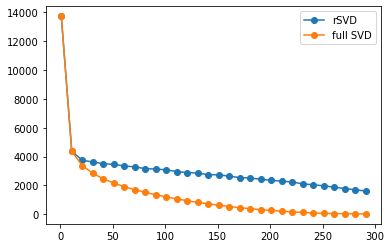

In [14]:
plt.plot(ranks, randomized_errors, '-o')
plt.plot(ranks, full_errors, '-o')
plt.legend(['rSVD', 'full SVD']);

## Compute time of rSVD

In [15]:
times = []
for r in range(1, 350, 10):
    times.append(timeit.timeit(f'rSVD(mt_emily, {r})', globals=globals(), number=50))

In [16]:
explained_variance = (S ** 2) / (378 - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
full_svd_time = timeit.timeit(f'np.linalg.svd(mt_emily)', globals=globals(), number=50)

In [17]:
full_faster = np.searchsorted(times, full_svd_time) * 10

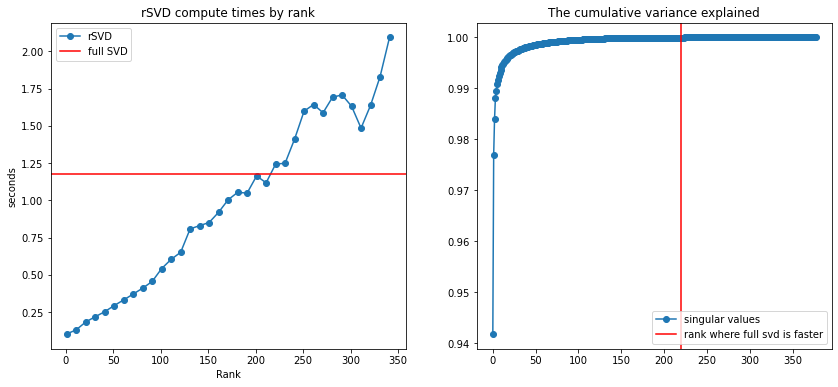

In [18]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))
ax1.plot(np.arange(1, 350, 10), times, 'o-')
ax1.axhline(y=full_svd_time, color='r')
ax1.set_ylabel('seconds')
ax1.set_xlabel('Rank')
ax1.set_title('rSVD compute times by rank')
ax1.legend(['rSVD', 'full SVD'])
ax2.plot(np.cumsum(explained_variance_ratio), 'o-')
ax2.axvline(x=full_faster, color='r')
ax2.set_title('The cumulative variance explained')
ax2.legend(['singular values', 'rank where full svd is faster']);

Let's see how the results of the rSVD compare with the full SVD:

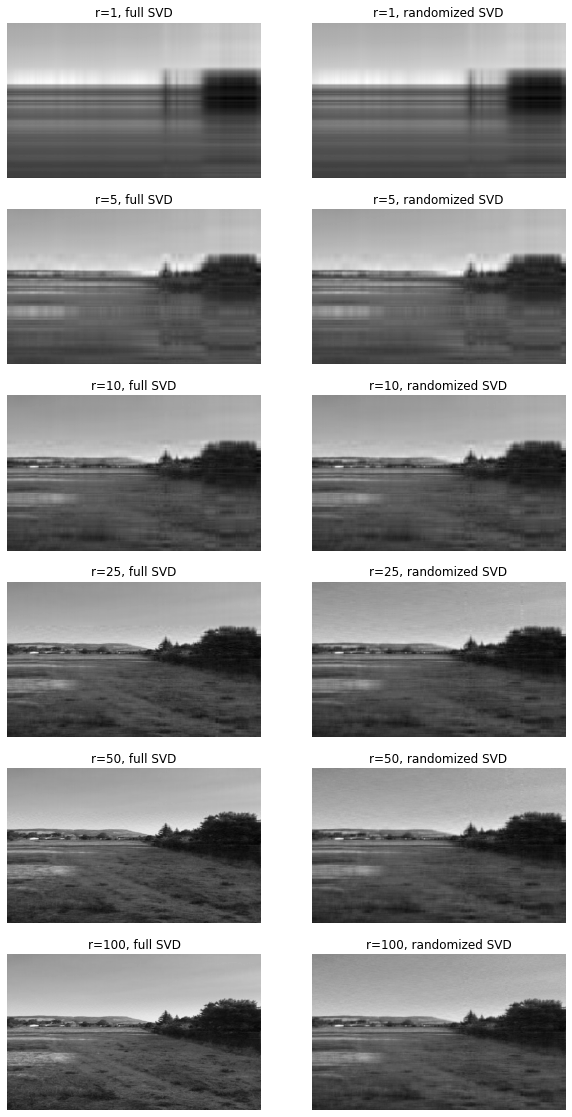

In [19]:
randomized_results = []
full_results = []
ranks = [1,5,10,25,50,100]
full_svd = Uf,Sf,Vtf = np.linalg.svd(mt_emily)
for r in ranks:
    U,S,Vt = rSVD(mt_emily, r)
    randomized_results.append(U[:,:r+1] @ np.diag(S[:r+1]) @ Vt[:r+1,:])
    full_results.append(Uf[:,:r+1] @ np.diag(Sf[:r+1]) @ Vtf[:r+1,:])
fig, axs = plt.subplots(6,2, figsize=(10,20))

plt.set_cmap('gray')

for i in range(len(ranks)):
    axs[i,0].imshow(full_results[i], aspect='auto')
    axs[i,0].axis('off')
    axs[i,0].set_title(f'r={ranks[i]}, full SVD')
    axs[i,1].imshow(randomized_results[i], aspect='auto')
    axs[i,1].axis('off')
    axs[i,1].set_title(f'r={ranks[i]}, randomized SVD')
plt.show()